In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Read in the Dataset

In [2]:
image_shape = (224, 224, 3)

dataset = tf.keras.utils.image_dataset_from_directory(
    directory="dataset/v4",
    image_size=image_shape[:2],
)

x, y = [], []
for batch in dataset.take(-1):
    images, labels = batch
    x.append(images.numpy())
    y.append(labels.numpy())

x = np.concatenate(x)
y = np.concatenate(y)

Found 3080 files belonging to 10 classes.


In [3]:
dataset.class_names

['Acral Lentiginous Melanoma',
 'Beaus Line',
 'Blue Finger',
 'Clubbing',
 'Healthy Nail',
 'Koilonychia',
 'Muehrckes Lines',
 'Onychogryphosis',
 'Pitting',
 'Terry-s Nail']

## Split into Train/Validation/Test at 80/10/10 Ratio

In [4]:
class_names = dataset.class_names
num_classes = len(class_names)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

In [5]:
print(
    f"total  : {np.unique(y, return_counts=True)[1]}\n"
    f"y_train: {np.unique(y_train, return_counts=True)[1]}\n"
    f"y_val  : {np.unique(y_val, return_counts=True)[1]}\n"
    f"y_test : {np.unique(y_test, return_counts=True)[1]}"
)

total  : [357 218 292 373 358 260 159 329 312 422]
y_train: [286 174 234 298 286 208 127 263 250 338]
y_val  : [36 22 29 37 36 26 16 33 31 42]
y_test : [35 22 29 38 36 26 16 33 31 42]


## Define Helpers

In [6]:
def plot_loss_and_accuracy(history) -> None:
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title("Loss")
    ax1.plot(history.history["loss"], label="Train")
    ax1.plot(history.history["val_loss"], label="Validation")
    ax1.legend(loc="best")

    ax2.set_title("Accuracy")
    ax2.plot(history.history["accuracy"], label="Train")
    ax2.plot(history.history["val_accuracy"], label="Validation")
    ax2.legend(loc="best")

    plt.show()

## Data Augmentation

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,  # degree
    horizontal_flip=True,
    vertical_flip=True,
)

datagen.fit(x_train)

## Train and Evaluate

In [ ]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=image_shape, include_top=False)

base_model.trainable = False

12683000/12683000 [==============================] - 2s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=image_shape)

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-4)

model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
batch_size = 4
epochs = 5

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                    validation_data=(x_val, y_val))

Epoch 1/5
616/616 [==============================] - 63s 94ms/step - loss: 1.5869 - accuracy: 0.4692 - val_loss: 1.1300 - val_accuracy: 0.6331
Epoch 2/5
616/616 [==============================] - 60s 97ms/step - loss: 0.9701 - accuracy: 0.6847 - val_loss: 0.9313 - val_accuracy: 0.6883
Epoch 3/5
616/616 [==============================] - 60s 97ms/step - loss: 0.7714 - accuracy: 0.7553 - val_loss: 0.8398 - val_accuracy: 0.7045
Epoch 4/5
616/616 [==============================] - 60s 97ms/step - loss: 0.6663 - accuracy: 0.7922 - val_loss: 0.8215 - val_accuracy: 0.7532
Epoch 5/5
616/616 [==============================] - 58s 94ms/step - loss: 0.5848 - accuracy: 0.8157 - val_loss: 0.7498 - val_accuracy: 0.7370


loss=0.7623, accuracy=0.7435


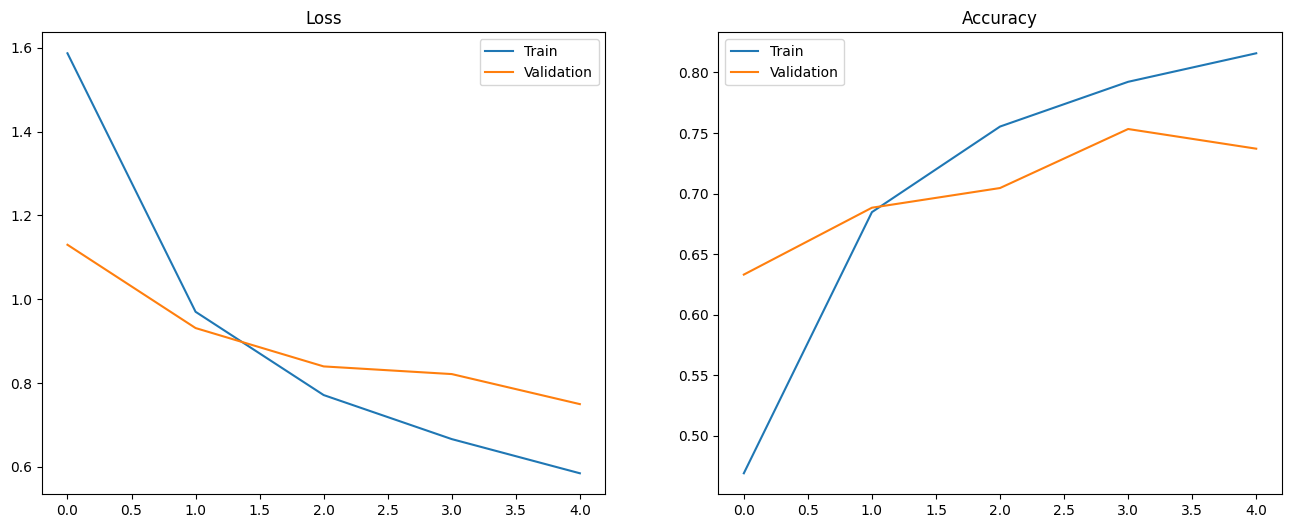

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f"{loss=:.4f}, {accuracy=:.4f}")
plot_loss_and_accuracy(history)

## Predict

In [ ]:
ISSUES_MAPPING = {
    "Acral Lentiginous Melanoma": "Acral Lentiginous Melanoma (ALM) is a rare form of skin cancer.",
    "Beaus Line": "Uncontrolled diabetes, peripheral vascular disease, zinc deficiency, illnesses associated with a high fever.",
    "Blue Finger": "Insufficient oxygen in blood, cold environment.",
    "Clubbing": "Lung or heart related diseases, mostly lung cancer.",
    "Healthy Nail": "No cause. Your nail is healthy. Congratulations!",
    "Koilonychia": "Too much or too low iron level, uncontrolled diabetes, heart disease, celiac disease, and celiac cancer.",
    "Muehrckes Lines": "Lack of nutrients, kidney disease, liver disease, cancer after chemotherapy.",
    "Onychogryphosis": "Foot trauma, fungal infection, autoimmune disease, peripheral vascular disease, ichthyosis.",
    "Pitting": "Connective tissue disorders, autoimmune disease, genetic disorder.",
    "Terry-s Nail": "Cirrhosis, heart failure, diabetes, kidney failure, viral hepatitis.",
}

In [ ]:
def predict(img, top_n=3):
    image = read_image(img) if isinstance(img, str) else img
    result = make_prediction(image, top_n=top_n)
    show_possible_health_issues(result)

    plt.imshow(image.astype("uint8"))
    plt.show()


def read_image(image_path):
    image = tf.keras.utils.load_img(image_path, target_size=image_shape[:2])
    return tf.keras.utils.img_to_array(image)


def make_prediction(image, top_n=3):
    [pred] = model.predict(np.expand_dims(image, axis=0), verbose=0)
    return [(class_names[idx], pred[idx]) for idx in pred.argsort()[::-1]][:top_n]


def show_possible_health_issues(result):
    for nail_disease, prob in result:
        print(f"({prob * 100:.2f}%) {nail_disease}")
        print(f"\tPossible cause: {ISSUES_MAPPING.get(nail_disease)}", end="\n\n")

In [ ]:
path = "test_images/beaus-line-01.jpg"

predict(path)

FileNotFoundError: [Errno 2] No such file or directory: 'test_images/beaus-line-01.jpg'

## Save and Load Model

In [ ]:
model_path = "saved_models/model_0.7597"

In [ ]:
model.save(model_path)

INFO:tensorflow:Assets written to: saved_models/model_0.7597\assets


INFO:tensorflow:Assets written to: saved_models/model_0.7597\assets


In [ ]:
model = tf.keras.models.load_model(model_path)